In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import Bio
Bio.__version__

'1.84'

In [26]:
from Bio.PDB import PDBParser
from Bio.PDB import PDBIO
from Bio.SeqUtils import seq1
import numpy as np
import os
import torch
import seaborn as sns
from utils.model_names import ESM_FOLD, ESM_CONTACT_HEAD
from utils.esm_true_structure_inference import seq_from_pdb, inference_from_pdb

In [4]:
pdb_path = '../data/cadherin/pdb2o72.ent'

In [5]:
parser = PDBParser()
protein_structure = parser.get_structure('2O72', pdb_path)
protein_structure

<Structure id=2O72>

Parse the PDB file into its amino acid sequence:

In [6]:
aa_seq = ''

for residue in next(protein_structure.get_chains()):
    # remove heteroatoms
    het = residue.get_full_id()[3][0]
    if het == ' ':
        aa_seq += residue.resname

seq1(aa_seq)

'DWVIPPISSPENEKGPFPKNLVQIKSNKDKEGKVFYSITGQGADTPPVGVFIIERETGWLKVTEPLDRERIATYTLFSHAVSSNGNAVEDPMEILITVTDQNDNKPEFTQEVFKGSVMEGALPGTSVMEVTATDADDDVNTYNAAIAYTILSQDPELPDKNMFTINRNTGVISVVTTGLDRESFPTYTLVVQAADLQGEGLSTTATAVITVTD'

In [7]:
# abstracted to utils function
seq = seq_from_pdb(pdb_path)
seq

'DWVIPPISSPENEKGPFPKNLVQIKSNKDKEGKVFYSITGQGADTPPVGVFIIERETGWLKVTEPLDRERIATYTLFSHAVSSNGNAVEDPMEILITVTDQNDNKPEFTQEVFKGSVMEGALPGTSVMEVTATDADDDVNTYNAAIAYTILSQDPELPDKNMFTINRNTGVISVVTTGLDRESFPTYTLVVQAADLQGEGLSTTATAVITVTD'

In [13]:
amino_acids = []

for residue in next(protein_structure.get_chains()):
    # remove heteroatoms
    het = residue.get_full_id()[3][0]
    if het == ' ':
        amino_acids.append(residue)

amino_acids

[<Residue ASP het=  resseq=1 icode= >,
 <Residue TRP het=  resseq=2 icode= >,
 <Residue VAL het=  resseq=3 icode= >,
 <Residue ILE het=  resseq=4 icode= >,
 <Residue PRO het=  resseq=5 icode= >,
 <Residue PRO het=  resseq=6 icode= >,
 <Residue ILE het=  resseq=7 icode= >,
 <Residue SER het=  resseq=8 icode= >,
 <Residue SER het=  resseq=9 icode= >,
 <Residue PRO het=  resseq=10 icode= >,
 <Residue GLU het=  resseq=11 icode= >,
 <Residue ASN het=  resseq=12 icode= >,
 <Residue GLU het=  resseq=13 icode= >,
 <Residue LYS het=  resseq=14 icode= >,
 <Residue GLY het=  resseq=15 icode= >,
 <Residue PRO het=  resseq=16 icode= >,
 <Residue PHE het=  resseq=17 icode= >,
 <Residue PRO het=  resseq=18 icode= >,
 <Residue LYS het=  resseq=19 icode= >,
 <Residue ASN het=  resseq=20 icode= >,
 <Residue LEU het=  resseq=21 icode= >,
 <Residue VAL het=  resseq=22 icode= >,
 <Residue GLN het=  resseq=23 icode= >,
 <Residue ILE het=  resseq=24 icode= >,
 <Residue LYS het=  resseq=25 icode= >,
 <Residue

Calculate pairwise Euclidean distances between atoms:

In [14]:
def min_residue_dist(res1, res2):
    res1_atoms = [a for a in res1.get_atoms()]
    res2_atoms = [a for a in res2.get_atoms()]

    min_dist = 1000
    for a_i in res1_atoms:
        for a_j in res2_atoms:
            min_dist = min(min_dist, np.linalg.norm(a_i - a_j))
    
    return min_dist

In [15]:
# d[i][j] = min euclidean dist between atoms in amino_acid[i] and atoms in amino_acid[j]
# i > j
pairwise_dists = {}

for i in range(len(amino_acids)):
    for j in range(i):
        #pairwise_dists[(i,j)] = np.linalg.norm(atom_coords[i] - atom_coords[j])
        pairwise_dists[(i,j)] = min_residue_dist(amino_acids[i], amino_acids[j])

pairwise_dists

{(1, 0): 1.3322872,
 (2, 0): 3.4894183,
 (2, 1): 1.3290927,
 (3, 0): 6.7644925,
 (3, 1): 4.7313166,
 (3, 2): 1.3302827,
 (4, 0): 8.981501,
 (4, 1): 7.5606728,
 (4, 2): 3.8433883,
 (4, 3): 1.354358,
 (5, 0): 11.148689,
 (5, 1): 10.568974,
 (5, 2): 7.11493,
 (5, 3): 3.703096,
 (5, 4): 1.3461472,
 (6, 0): 14.242777,
 (6, 1): 12.297987,
 (6, 2): 8.951379,
 (6, 3): 4.463689,
 (6, 4): 3.3395503,
 (6, 5): 1.3182056,
 (7, 0): 17.57514,
 (7, 1): 16.161163,
 (7, 2): 12.571122,
 (7, 3): 8.38166,
 (7, 4): 6.388025,
 (7, 5): 3.9663308,
 (7, 6): 1.3301528,
 (8, 0): 20.858185,
 (8, 1): 19.383562,
 (8, 2): 15.807729,
 (8, 3): 11.427397,
 (8, 4): 9.71209,
 (8, 5): 7.400372,
 (8, 6): 4.0949416,
 (8, 7): 1.3260626,
 (9, 0): 24.328709,
 (9, 1): 22.785297,
 (9, 2): 19.212011,
 (9, 3): 14.688079,
 (9, 4): 13.14698,
 (9, 5): 10.848616,
 (9, 6): 7.550299,
 (9, 7): 4.4695582,
 (9, 8): 1.3502744,
 (10, 0): 26.961224,
 (10, 1): 25.599104,
 (10, 2): 22.055185,
 (10, 3): 17.72825,
 (10, 4): 16.004852,
 (10, 5): 13

Contacts are pairs of residues that are within 8 Angstroms of each other. Residues that are within the sequence separation cutoff are considered neighbor pairs, so they are not factored in as contacts. See the DCA paper (Ekeberg et al.) for more details.

In [16]:
contact_dist_cutoff = 8.0
seq_separation_cutoff = 4
contacts = []

for i in range(len(amino_acids)):
    for j in range(i):
        if abs(i - j) > seq_separation_cutoff and pairwise_dists[(i,j)] <= contact_dist_cutoff:
            contacts.append([i, j])

contacts

[[12, 7],
 [16, 8],
 [16, 9],
 [16, 10],
 [16, 11],
 [17, 12],
 [18, 8],
 [18, 9],
 [18, 11],
 [18, 12],
 [18, 13],
 [19, 6],
 [19, 7],
 [19, 8],
 [19, 12],
 [20, 3],
 [20, 6],
 [20, 7],
 [20, 8],
 [20, 9],
 [20, 12],
 [21, 3],
 [21, 4],
 [21, 6],
 [22, 3],
 [22, 6],
 [23, 3],
 [23, 6],
 [24, 1],
 [24, 3],
 [28, 23],
 [29, 24],
 [30, 25],
 [31, 25],
 [31, 26],
 [32, 27],
 [33, 24],
 [33, 25],
 [33, 26],
 [33, 27],
 [33, 28],
 [34, 23],
 [34, 25],
 [34, 28],
 [35, 22],
 [35, 23],
 [35, 24],
 [35, 25],
 [35, 26],
 [35, 27],
 [35, 28],
 [35, 29],
 [36, 23],
 [37, 20],
 [37, 23],
 [42, 36],
 [42, 37],
 [43, 37],
 [43, 38],
 [44, 37],
 [44, 38],
 [44, 39],
 [45, 39],
 [45, 40],
 [46, 39],
 [46, 40],
 [46, 41],
 [47, 39],
 [47, 40],
 [47, 41],
 [47, 42],
 [48, 17],
 [48, 37],
 [48, 39],
 [48, 40],
 [48, 41],
 [48, 42],
 [48, 43],
 [49, 16],
 [49, 17],
 [49, 18],
 [49, 20],
 [49, 37],
 [49, 39],
 [49, 40],
 [49, 41],
 [49, 42],
 [49, 43],
 [49, 44],
 [50, 6],
 [50, 8],
 [50, 17],
 [50, 18],
 

In [20]:
real_contacts_path = os.path.join('..', 'data', 'cadherin', 'PF00028_real_contacts.csv')
np.savetxt(real_contacts_path, np.array(contacts), delimiter=",")

For the purposes of calculating the Top-L long-range precision score, we will treat these contacts as "ground truth".

## ESM inference on pdb sequence

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
# ESMFOLD inference on pdb structure
esmfold_output = inference_from_pdb(ESM_FOLD, pdb_path, device)

STARTING INFERENCE...


Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FINISHED


In [ ]:
# output should be LxL where L is the length of seq
assert esmfold_output.shape == (len(seq), len(seq))

<Axes: >

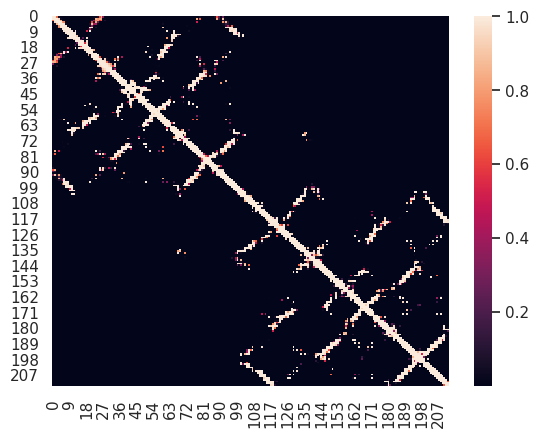

In [22]:
sns.set_theme()
sns.heatmap(esmfold_output)

In [27]:
esm_contacthead_output = inference_from_pdb(ESM_CONTACT_HEAD, pdb_path, device)

STARTING INFERENCE...


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FINISHED


In [29]:
# output should be LxL where L is the length of seq
assert esm_contacthead_output.shape == (len(seq), len(seq))

<Axes: >

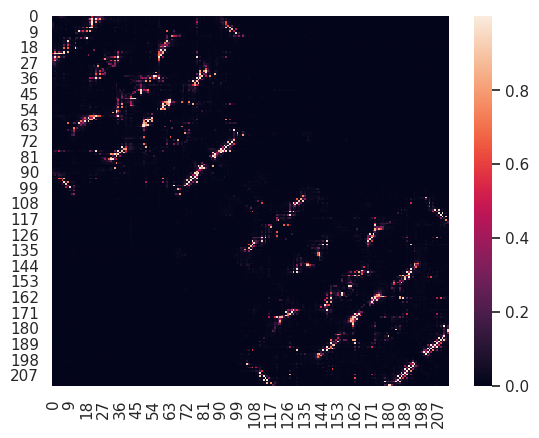

In [30]:
sns.set_theme()
sns.heatmap(esm_contacthead_output)